In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

Mounted at /content/drive


In [ ]:
import pandas as pd

def clean_text(text_series):
    """
    Cleans text data by removing URLs and HTML entities.

    Parameters:
    text_series (Series): Pandas Series containing text data.

    Returns:
    Series: Cleaned text data.
    """
    # Remove URLs from text
    text_series = text_series.str.replace(
        r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|'
        r'(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)
    # Remove HTML entities like '&gt;'
    text_series = text_series.str.replace('&gt;', '')
    return text_series

def add_datetime_columns(df, time_column='created_utc'):
    """
    Adds 'Y' (year) and 'YM' (year-month) columns to the DataFrame based on a timestamp column.

    Parameters:
    df (DataFrame): The DataFrame to modify.
    time_column (str): Name of the timestamp column.

    Returns:
    DataFrame: The modified DataFrame with added 'Y' and 'YM' columns.
    """
    # Convert timestamp to datetime and extract the year
    df['Y'] = pd.to_datetime(df[time_column], unit='s').dt.year
    # Extract year-month in 'YYYY-MM' format
    df['YM'] = pd.to_datetime(df[time_column], unit='s').dt.strftime('%Y-%m')
    return df

def submission_comment_process(subreddit, min_num_comments=3, min_score=-1, years=[2016], chunk_size=10**6):
    """
    Processes submissions and comments for a given subreddit and returns cleaned DataFrames.

    Parameters:
    subreddit (str): Name of the subreddit.
    min_num_comments (int): Minimum number of comments required for a submission.
    min_score (int): Minimum score required for a submission.
    years (list): List of years to include in the data.
    chunk_size (int): Number of rows per chunk when reading comments CSV.

    Returns:
    DataFrame, DataFrame: Cleaned submissions and comments DataFrames.
    """
    # Read submissions CSV file
    df_s = pd.read_csv(f'drive/MyDrive/Reddit/Data_Sets/{subreddit}_submissions.csv')
    # Alternative path (commented out)
    # df_s = pd.read_csv('drive/MyDrive/Reddit/path in g drive')

    # Add 'Y' and 'YM' columns to submissions DataFrame
    df_s = add_datetime_columns(df_s, 'created_utc')
    # Filter submissions by specified years
    df_s = df_s[df_s['Y'].isin(years)]
    print(f"{subreddit}: # submissions {len(df_s)}")

    # Filter submissions based on minimum score and number of comments
    df_s = df_s[df_s['score'] > min_score]
    df_s = df_s[df_s['num_comments'] >= min_num_comments]
    # Add subreddit name to DataFrame
    df_s['sub'] = subreddit
    print(f"{subreddit}: # submissions after cleaning {len(df_s)}")
    print('Submissions processing done.')

    # Start processing comments
    print('Starting processing comments')
    # Read comments CSV file in chunks
    comments_chunks = pd.read_csv(
        f'drive/MyDrive/Reddit/Data_Sets/{subreddit}_comments.csv', chunksize=chunk_size)
    # Alternative path (commented out)
    # comments_chunks = pd.read_csv('drive/MyDrive/Reddit/path in g drive', chunksize=chunk_size)

    df_c = pd.DataFrame()  # Initialize empty DataFrame for comments

    for i, chunk in enumerate(comments_chunks):
        # Remove 't3_' prefix from 'link_id'
        chunk['link_id'] = chunk['link_id'].str.replace('t3_', '')
        # Keep only comments linked to the filtered submissions
        chunk = chunk[chunk['link_id'].isin(df_s['id'].unique())]
        print(f"Chunk {i}: {len(chunk)} comments after filtering")

        # The following lines are commented out; they can be used for additional filtering
        # Remove comments with missing 'body' (commented out)
        # chunk = chunk[~chunk['body'].isna()]
        # Remove comments where 'author' is '[deleted]' (commented out)
        # chunk = chunk[chunk['author'] != '[deleted]']
        # Remove comments where 'body' is '[removed]' (commented out)
        # chunk = chunk[chunk['body'] != '[removed]']

        # Remove prefix from 'parent_id'
        chunk['parent_id'] = chunk['parent_id'].str[3:]
        # Keep only comments with at least 3 words in 'body' (commented out)
        # chunk = chunk[chunk['body'].str.split().str.len() >= 3]

        # Add 'Y' and 'YM' columns to comments DataFrame
        chunk = add_datetime_columns(chunk, 'created_utc')

        # Break the loop if the chunk's years are beyond the specified range
        if chunk['Y'].min() > max(years):
            break

        # Clean the 'body' text in comments
        chunk['body'] = clean_text(chunk['body'])
        # Add subreddit name to DataFrame
        chunk['sub'] = subreddit

        # Concatenate the processed chunk to the main comments DataFrame
        df_c = pd.concat([df_c, chunk], ignore_index=True)

    print(f"{subreddit}: # comments {len(df_c)}")

    # Remove 't3_' prefix from 'link_id' in comments (redundant but kept for consistency)
    df_c['link_id'] = df_c['link_id'].str.replace('t3_', '')
    # Keep only comments linked to the filtered submissions
    df_c = df_c[df_c['link_id'].isin(df_s['id'].unique())]

    # The following lines are commented out; they can be used for additional filtering
    # Remove comments where 'author' is '[deleted]' (commented out)
    # df_c = df_c[df_c['author'] != '[deleted]']
    # Remove comments where 'body' is '[deleted]' or '[removed]' (commented out)
    # df_c = df_c[~df_c['body'].isin(['[deleted]', '[removed]'])]
    # Remove comments with missing 'body' (commented out)
    # df_c = df_c[~df_c['body'].isna()]
    # Keep only comments with at least 3 words in 'body' (commented out)
    # df_c = df_c[df_c['body'].str.split().str.len() >= 3]

    # The following line is commented out; it might be for adding a 'Cred' column based on domain
    # df_c['B'] = df_c['domain'].map(df_crd.set_index("Domain")["Cred"])

    print(f"{subreddit}: # comments after cleaning {len(df_c)}")
    print('Finished processing comments')
    return df_s, df_c

def P2P_Multi(Subreddits, min_num_comments=0, min_score=-1, years=[2017]):
    """
    Processes multiple subreddits and aggregates the submissions and comments.

    Parameters:
    Subreddits (list): List of subreddit names.
    min_num_comments (int): Minimum number of comments required for a submission.
    min_score (int): Minimum score required for a submission.
    years (list): List of years to include in the data.

    Returns:
    DataFrame, DataFrame: Aggregated submissions and comments DataFrames.
    """
    Df_S = pd.DataFrame()  # Initialize empty DataFrame for submissions
    Df_C = pd.DataFrame()  # Initialize empty DataFrame for comments

    for subreddit in Subreddits:
        # Process each subreddit and get cleaned DataFrames
        df_s, df_c = submission_comment_process(
            subreddit, min_num_comments, min_score, years)
        # Concatenate the results to the aggregated DataFrames
        Df_S = pd.concat([Df_S, df_s], ignore_index=True)
        Df_C = pd.concat([Df_C, df_c], ignore_index=True)

    return Df_S, Df_C

# List of subreddits to process
Subreddits = ["climateskeptics"]

# Process the subreddits and get aggregated submissions and comments
DS, DC = P2P_Multi(Subreddits, min_num_comments=0, min_score=-1, years=range(2016, 2017))

# Filter submissions to only include those with comments in DC
DS = DS[DS['sub'].isin(DC['sub'].unique())]

print('Overall Submissions:', len(DS))
print('Overall Comments:', len(DC))


climateskeptics: # submissions 3995
climateskeptics: # submissions after cleaning 3995
Submissions processing done.
Starting processing comments
Chunk 0: 28348 comments after filtering
climateskeptics: # comments 28348
climateskeptics: # comments after cleaning 28348
Finished processing comments
Overall Submissions: 3995
Overall Comments: 28348


In [ ]:
# sample submission data
DS.head(10)

,Index,id,author,author_flair_text,created_utc,num_comments,score,domain,title,Y,YM,sub
0,26922,3yyzzm,TheFerretman,NaN,1451609314,13,4,bbc.com,Should we solar panel the Sahara desert?,2016,2016-01,climateskeptics
1,26923,3yz24v,Kim147,NaN,1451610576,1,4,abc.net.au,Hawke government considered carbon tax in 1991...,2016,2016-01,climateskeptics
2,26924,3yz649,logicalprogressive,NaN,1451613044,1,11,news.investors.com,Three More Global Warming Stories Media Don't ...,2016,2016-01,climateskeptics
3,26925,3yz6nh,logicalprogressive,NaN,1451613378,1,2,wattsupwiththat.com,Local Journalists Condemn Pakistan Government ...,2016,2016-01,climateskeptics
4,26926,3yzbjr,Kim147,NaN,1451616443,0,5,dallasnews.com,"Damage survey engineer finds that ""horrific co...",2016,2016-01,climateskeptics
5,26927,3z0obs,sand_mann,NaN,1451656861,1,0,wattsupwiththat.com,WUWT Year in review for 2015,2016,2016-01,climateskeptics
6,26928,3z12ba,pr-mth-s,NaN,1451665746,14,5,quadrant.org.au,The Fishy ‘Science’ of Ocean Acidification,2016,2016-01,climateskeptics
7,26929,3z1d6e,logicalprogressive,NaN,1451670951,3,13,joannenova.com.au,Global Warming Makes You Go Nuts: CO2 Causes PTSD,2016,2016-01,climateskeptics
8,26930,3z1dt3,logicalprogressive,NaN,1451671249,3,3,wattsupwiththat.com,National Black Chamber of Commerce Upsets The ...,2016,2016-01,climateskeptics
9,26931,3z1ec5,logicalprogressive,NaN,1451671480,15,14,thelukewarmersway.wordpress.com,A Fascinating Survey on Climate Change of Scie...,2016,2016-01,climateskeptics


In [ ]:
# sample comment data
DC.head(10)

,Index,id,author,created_utc,parent_id,link_id,body,Y,YM,sub
0,159397,cyhvlkd,ozric101,1451610210,3yyzzm,3yyzzm,The entire place? NO..,2016,2016-01,climateskeptics
1,159400,cyhvz5z,logicalprogressive,1451610983,3yyzzm,3yyzzm,"Sounds legit.. wait,.. where do the transmissi...",2016,2016-01,climateskeptics
2,159402,cyhw0le,Kim147,1451611067,3yyzzm,3yyzzm,As with all projects of this type they need to...,2016,2016-01,climateskeptics
3,159403,cyhw8ia,Kim147,1451611516,3yz24v,3yz24v,,2016,2016-01,climateskeptics
4,159409,cyhws2w,logicalprogressive,1451612642,cyhw0le,3yyzzm,Good ideas except for the fact the whole regio...,2016,2016-01,climateskeptics
5,159410,cyhx1g4,logicalprogressive,1451613179,3yz649,3yz649,"Missed story No. 2: Greenland, the alarmists' ...",2016,2016-01,climateskeptics
6,159411,cyhx7jh,logicalprogressive,1451613534,3yz6nh,3yz6nh,Snowfall that was expected in February began i...,2016,2016-01,climateskeptics
7,159412,cyhxeni,Kim147,1451613964,cyhws2w,3yyzzm,I certainly don't disagree with what you say. ...,2016,2016-01,climateskeptics
8,159413,cyhxmmq,wral,1451614436,3yyzzm,3yyzzm,"""As an African, knowing the history about the...",2016,2016-01,climateskeptics
9,159416,cyhyrdh,ozric101,1451616822,cyhxmmq,3yyzzm,IF anyone traces their family tree back far en...,2016,2016-01,climateskeptics


#Networkx

In [ ]:
import networkx as nx
import numpy as np
f=pd.crosstab(DC['link_id'],DC['author'])
A=np.array((f.values).astype(float))
E=A@A.T
np.fill_diagonal(E,0)
print(E)
min_num_shared_user=2
Adj=np.array(E>min_num_shared_user)
G=nx.from_numpy_array(Adj)
# print(# Graph Nodes:’, len(G.nodes))
# for v in nx.nodes(G):
    # G.nodes[v]["sub"] = DS_b.iloc[v]["sub"]
nx.write_gexf(G, 'Graph_Final2.gexf')

[[0. 4. 4. ... 0. 4. 4.]
 [4. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 1. ... 0. 0. 1.]
 [4. 0. 1. ... 0. 1. 0.]]


In [ ]:
ds=DS[DS['id']==sbm]
dc=DC[DC['link_id']==sbm]


NameError: name 'sbm' is not defined

In [ ]:
import pandas as pd


data = DC[DC['link_id']==sbm]

# Filter necessary columns
comments = data[['id', 'parent_id', 'body']]

# Initialize the comment tree with the root link_id
link_id = sbm  # Assuming '5j5otc' is the link_id for root comments
comment_tree = {link_id: []}

# Function to add comment to the tree
def add_to_tree(comment_id, parent_id, comment_body):
    if parent_id == link_id:  # Handling root comments
        if parent_id not in comment_tree:
            comment_tree[parent_id] = []
        comment_tree[parent_id].append({'id': comment_id, 'body': comment_body, 'replies': []})
    else:
        # Recursively find the parent and add the comment as a reply
        find_and_add(parent_id, comment_tree[link_id], {'id': comment_id, 'body': comment_body, 'replies': []})

# Recursive function to find the parent in the tree and add the current comment
def find_and_add(parent_id, current_level, comment):
    for entry in current_level:
        if entry['id'] == parent_id:
            entry['replies'].append(comment)
            return True
        if find_and_add(parent_id, entry['replies'], comment):
            return True
    return False

# Build the tree by iterating over each comment
for _, row in comments.iterrows():
    add_to_tree(row['id'], row['parent_id'], row['body'])

# Optional: Function to print the tree in a structured manner for better readability
def print_tree(level, indent=0):
    for node in level:
        print(' ' * indent + f"Comment ID: {node['id']}, Body: {node['body'][:60]}...")  # Print truncated body
        if node['replies']:
            print_tree(node['replies'], indent + 4)

# Example usage: Print the first few levels of the tree
print_tree(comment_tree[link_id][:2])  # Adjust as needed for full tree or specific sections


Comment ID: d0nbtkg, Body: CJWs are totalitarians..  They need their safe space. ...
    Comment ID: d0npa00, Body: It's not merely that they need a safe space, it's that *no o...
        Comment ID: d0o1n89, Body: it's that no one else can have one

at least you admit that'...
            Comment ID: d0o1xgh, Body: No different from /r skeptic, /r socialism or /r climate. If...
                Comment ID: d0o2zlt, Body: otherwise, what are you still doing here?

As deplorable as ...
                    Comment ID: d0o4xaz, Body: and there hasn't been a reason to ban me  

Because we don't...
                        Comment ID: d0o51p8, Body: Funny how climate skeptics get offended when people attack d...
                            Comment ID: d0o5bwk, Body: It's kind of like how alarmists can't seem to distinguish th...
                                Comment ID: d0os871, Body: Really?  You think they don't comprehend that the climate ch...
                            Comment ID: d0o

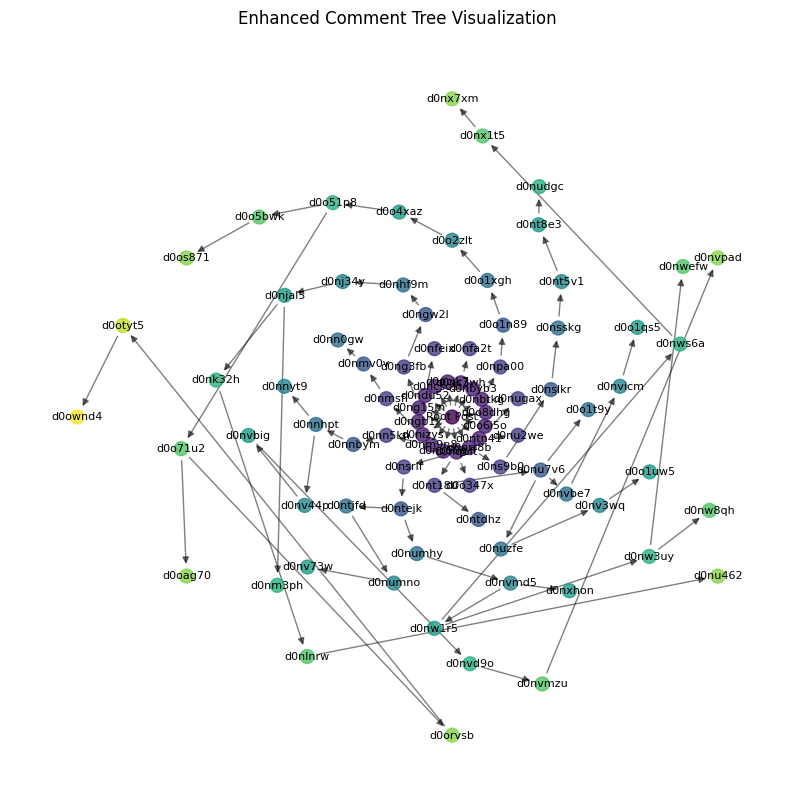

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming DC and sbm are defined somewhere earlier in your code
data = DC[DC['link_id'] == sbm]
fig, ax = plt.subplots(figsize=(10, 10))

# Filter necessary columns
comments = data[['id', 'parent_id', 'body']]

# Create a directed graph
G = nx.DiGraph()

# Define a root node for visualization and add nodes and edges
root_node = 'Root'
G.add_node(root_node, body="Root Post")
for _, row in comments.iterrows():
    G.add_node(row['id'], body=row['id'])  # Use full ID for display
    parent_id = row['parent_id'] if not row['parent_id'].startswith(sbm) else root_node
    G.add_edge(parent_id, row['id'])

# Compute depth for each node for shell assignment
depth = nx.single_source_shortest_path_length(G, root_node)
# Create shell layout based on depths
max_depth = max(depth.values())
shells = [[] for _ in range(max_depth + 1)]
for node, d in depth.items():
    shells[d].append(node)

# Define node colors based on depth with a more vibrant color map
node_color = [depth[node] / max_depth for node in G.nodes()]

if 1:
  # Draw the graph using the shell layout
  pos = nx.shell_layout(G, shells)
else:
  pos = nx.spring_layout(G, k=0.1, iterations=50)  # Adjust k and iterations for better layout

nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=100, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={n: G.nodes[n]['body'] for n in G.nodes}, font_size=8)

plt.title("Enhanced Comment Tree Visualization")
plt.axis('off')  # Hide axes
plt.show()
